In [ ]:
import os
import zipfile

In [ ]:
with zipfile.ZipFile('/content/iu_xray.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset_directory')

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Masking
from tensorflow.keras.utils import to_categorical, plot_model
import json
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt
from efficientnet.tfkeras import EfficientNetB0

In [ ]:
BASE_DIR = '/content/dataset_directory/iu_xray'
IMAGES_DIR = os.path.join(BASE_DIR, 'images')

In [ ]:
with open(os.path.join(BASE_DIR, 'annotation.json'), 'r') as f:
    annotations = json.load(f)

In [ ]:
train_data = annotations['train']
val_data = annotations['val']
test_data = annotations['test']

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False)
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, None, None, 32) │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, None, None, 16) │            512 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn   

 Total params: 4,049,564 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,016 (164.12 KB)

None


In [ ]:
features = {}

In [ ]:
for folder in tqdm(os.listdir(IMAGES_DIR)):
    folder_path = os.path.join(IMAGES_DIR, folder)

    # If it's a directory, process each image inside
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            if img_file.endswith(".png"):  # Process only PNG files
                img_path = os.path.join(folder_path, img_file)
                image = load_img(img_path, target_size=(224, 224))
                image = img_to_array(image)
                image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
                image = preprocess_input(image)  # Preprocessing for EfficientNetB0
                feature = model.predict(image, verbose=0)
                image_id = folder  # Folder name corresponds to the image ID
                features[image_id] = feature

  0%|          | 0/2955 [00:00<?, ?it/s]

In [ ]:
pickle.dump(features, open(os.path.join('/content/', 'EfficientNetB0features.pkl'), 'wb'))

In [ ]:
with open(os.path.join('/content/', 'EfficientNetB0features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
mapping = {}
for entry in tqdm(train_data):
    image_id = entry['id']
    caption = entry['report']
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/2069 [00:00<?, ?it/s]

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', ' ')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [ ]:
clean(mapping)

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train_ids = image_ids[:split]
test_ids = image_ids[split:]

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Reshape the feature to (4096,) before appending
                    # The error was here. features[key][0] was not reshaped to (4096,)
                    # before appending, likely it has a shape of (7, 7, 1280).
                    # Flatten it to (62720,) and then select the first 4096 elements
                    # to match the input shape of the model.
                    feature = features[key][0].reshape(-1)[:4096]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)

                yield (tf.convert_to_tensor(X1), tf.convert_to_tensor(X2)), tf.convert_to_tensor(y)

                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
output_signature = (
    (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # X1 (image features) - Now correctly shaped
     tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),  # X2 (sequence)
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y (target word)
)

In [ ]:
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size=32),
    output_signature=output_signature
)

In [ ]:
# Build the captioning model
inputs1 = Input(shape=(4096,))  # Input for image features, change the input shape

# fe1 = base_model(inputs1)  # Now base_model should receive the correct input shape
# fe1 = Dropout(0.4)(fe1)
# fe2 = Dense(256, activation='relu')(fe1)
fe2 = Dense(256, activation='relu')(inputs1)  # Directly use image features

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, return_sequences=False, return_state=False, dropout=0.4, recurrent_dropout=0.4)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 20
steps = len(train_ids) // 32

In [150]:
model.fit(dataset, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 495ms/step - loss: 39.8786
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 513ms/step - loss: 6.5536
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 494ms/step - loss: 5.2049
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 515ms/step - loss: 4.4954
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 535ms/step - loss: 3.9474
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 487ms/step - loss: 3.5657
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 509ms/step - loss: 3.2759
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 492ms/step - loss: 3.0641
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 485ms/step - loss: 2.8987
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 491ms/step - loss: 2.7559
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 503ms/step - loss: 2.6386
Epoch 12/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 496ms/step - loss: 2.5511
Epoch 13/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 491ms/step - loss: 2.4788
Epoch 14/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 488ms/step - loss: 2.4096
Epoch 15/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s

In [152]:
model.save(os.path.join('/content/', 'EfficientNetB0Epoch20.keras'))

In [153]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [157]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    # Reshape the image feature before prediction
    image = image.reshape(1, -1)[:, :4096]
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [158]:
actual, predicted = list(), list()

In [159]:
for key in tqdm(test_ids):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

  0%|          | 0/207 [00:00<?, ?it/s]

In [160]:
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.357969
BLEU-2: 0.174724
BLEU-3: 0.107652
BLEU-4: 0.059812


In [161]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import random

In [162]:
def display_image_and_reports(image_id, features, mapping, tokenizer, max_length):
    # Load the test image
    img_folder_path = os.path.join(IMAGES_DIR, image_id)
    img_file = os.listdir(img_folder_path)[0]  # Assuming one image per folder
    img_path = os.path.join(img_folder_path, img_file)

    # Display the image
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Get the ground truth captions
    original_report = mapping[image_id]

    # Generate the report using the model
    generated_report = predict_caption(model, features[image_id], tokenizer, max_length)

    # Print both
    print("Original Report(s):")
    for i, caption in enumerate(original_report):
        print(f"{i + 1}. {caption}")
    print("\nGenerated Report:")
    print(generated_report)

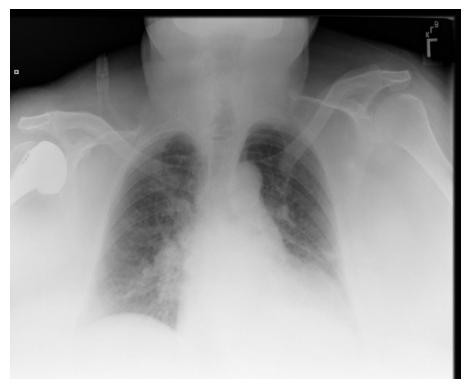

Original Report(s):
1. startseq ap and lateral view of the chest. endseq

Generated Report:
startseq the heart is normal in size the mediastinum is unremarkable the lungs are clear without evidence of focal airspace disease pleural effusion or pneumothorax is seen no acute bony abnormality endseq


In [163]:
random_test_id = random.choice(test_ids)
display_image_and_reports(random_test_id, features, mapping, tokenizer, max_length)

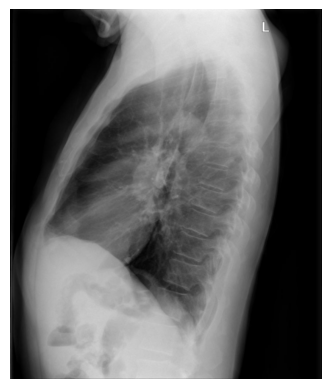

Original Report(s):
1. startseq heart size is within normal limits. 8mm calcified granuloma in the right base. no focal airspace consolidations. no pneumothorax or effusion. endseq

Generated Report:
startseq the heart is normal in size the mediastinum is unremarkable the lungs are clear without evidence of focal airspace disease pleural effusion or pneumothorax is seen no acute bony abnormality endseq


In [168]:
random_test_id = random.choice(test_ids)
display_image_and_reports(random_test_id, features, mapping, tokenizer, max_length)

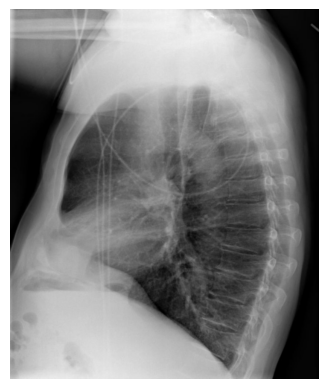

Original Report(s):
1. startseq the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. the lungs are mildly hyperinflated with flattening of the diaphragms and expansion of the retrosternal clear space. compared with prior exam, there has been interval resolution of previously demonstrated bibasilar infiltrates. there is minimal xxxx scarring or atelectasis in the right midlung. there is no xxxx focal airspace disease. there is no pneumothorax or pleural effusion. there are no acute bony findings. endseq

Generated Report:
startseq the heart is normal in size the mediastinum is unremarkable the lungs are clear without evidence of focal airspace disease pleural effusion or pneumothorax is seen no acute bony abnormality endseq


In [169]:
random_test_id = random.choice(test_ids)
display_image_and_reports(random_test_id, features, mapping, tokenizer, max_length)

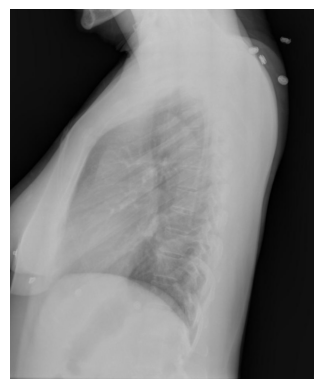

Original Report(s):
1. startseq normal cardiac contours. no pneumothorax or pleural effusions. clear left lung xxxx. right middle lobe with increased opacities, xxxx representative of infiltrate. endseq

Generated Report:
startseq the heart is normal in size the mediastinum is unremarkable the lungs are clear without evidence of focal airspace disease pleural effusion or pneumothorax is seen no acute bony abnormality endseq


In [170]:
random_test_id = random.choice(test_ids)
display_image_and_reports(random_test_id, features, mapping, tokenizer, max_length)

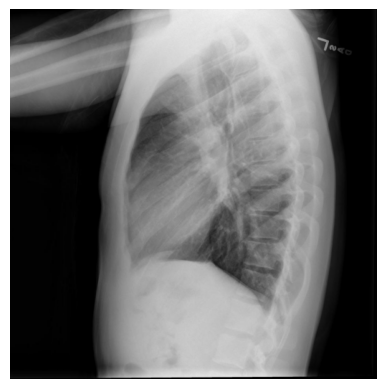

Original Report(s):
1. startseq heart size normal. no focal airspace disease. no pneumothorax or effusions. no bony abnormalities. endseq

Generated Report:
startseq the heart is normal in size the mediastinum is unremarkable the lungs are clear without evidence of focal airspace disease pleural effusion or pneumothorax is seen no acute bony abnormality endseq


In [171]:
random_test_id = random.choice(test_ids)
display_image_and_reports(random_test_id, features, mapping, tokenizer, max_length)

In [172]:
precision_list = []
recall_list = []
f1_list = []

In [173]:
for image_id in tqdm(test_ids):
    # Ground truth
    ground_truth_captions = mapping[image_id]
    ground_truth = ground_truth_captions[0]  # Use the first ground truth caption

    # Predicted
    predicted_caption = predict_caption(model, features[image_id], tokenizer, max_length)

    # Tokenize
    ground_truth_tokens = ground_truth.split()
    predicted_tokens = predicted_caption.split()

    # Align token lists by padding shorter lists
    max_len = max(len(ground_truth_tokens), len(predicted_tokens))
    ground_truth_tokens.extend(['<pad>'] * (max_len - len(ground_truth_tokens)))
    predicted_tokens.extend(['<pad>'] * (max_len - len(predicted_tokens)))

    # Convert tokens to binary format for metrics
    y_true = [1 if token in ground_truth_tokens else 0 for token in predicted_tokens]
    y_pred = [1 if token in predicted_tokens else 0 for token in predicted_tokens]

    # Compute precision, recall, F1
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

  0%|          | 0/207 [00:00<?, ?it/s]

In [174]:
avg_precision = sum(precision_list) / len(precision_list)
avg_recall = sum(recall_list) / len(recall_list)
avg_f1 = sum(f1_list) / len(f1_list)

In [175]:
print("\nEvaluation Metrics:")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")


Evaluation Metrics:
Average Precision: 0.3784
Average Recall: 1.0000
Average F1 Score: 0.5367
